#### Question: How well can we predict customer churn based on demographic features (gender, SeniorCitizen, Partner, and Dependents)?

##### Expectations
 This can be a useful question for the telecommunications company, as it can help them to understand which factors are most important in driving customer churn and how they can take targeted actions to reduce churn rates. By analyzing the data and building a predictive model, the company can gain insights into which demographic features are most strongly associated with churn, and use this information to develop retention strategies that are tailored to different customer segments.

##### Information about the data:
The data is stored in an Excel file named `Telco_customer_churn_demographics.xlsx`. The file contains 7043 rows. Each row represents a customer, each column contains customer’s attributes described on the column Metadata. The demographic feature that we have are: 
1. Gender
2. Age
3. Marriage status
4. Dependents

#### EDA

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# Load the data from /Dataset/Telco_customer_churn_demographics.xlsx
dataset1 = pd.read_excel('../Dataset/Telco_customer_churn_demographics.xlsx')

In [3]:
# we need to get a column from another excel file and join it with the dataset

# Load the data from /Dataset/Telco_customer_churn.xlsx
dataset2 = pd.read_excel('../Dataset/Telco_customer_churn.xlsx')

In [4]:
# rename the column to match the column name in the dataset
dataset2.rename(columns={'CustomerID':'Customer ID'}, inplace=True)

In [5]:
# Join the two datasets on the column 'Customer ID'
dataset = pd.merge(dataset1, dataset2, on='Customer ID')

In [6]:
# Check for any missing values
dataset.isnull().sum()

Customer ID                0
Count_x                    0
Gender_x                   0
Age                        0
Under 30                   0
Senior Citizen_x           0
Married                    0
Dependents_x               0
Number of Dependents       0
Count_y                    0
Country                    0
State                      0
City                       0
Zip Code                   0
Lat Long                   0
Latitude                   0
Longitude                  0
Gender_y                   0
Senior Citizen_y           0
Partner                    0
Dependents_y               0
Tenure Months              0
Phone Service              0
Multiple Lines             0
Internet Service           0
Online Security            0
Online Backup              0
Device Protection          0
Tech Support               0
Streaming TV               0
Streaming Movies           0
Contract                   0
Paperless Billing          0
Payment Method             0
Monthly Charge

In [7]:
# make sure that the merge happened successfully by comparing Gender_x and Gender_y columns to be the same
difference = dataset['Gender_x'] != dataset['Gender_y']
difference.sum()

0

In [8]:
# check the data types of the columns
dataset.dtypes

Customer ID              object
Count_x                   int64
Gender_x                 object
Age                       int64
Under 30                 object
Senior Citizen_x         object
Married                  object
Dependents_x             object
Number of Dependents      int64
Count_y                   int64
Country                  object
State                    object
City                     object
Zip Code                  int64
Lat Long                 object
Latitude                float64
Longitude               float64
Gender_y                 object
Senior Citizen_y         object
Partner                  object
Dependents_y             object
Tenure Months             int64
Phone Service            object
Multiple Lines           object
Internet Service         object
Online Security          object
Online Backup            object
Device Protection        object
Tech Support             object
Streaming TV             object
Streaming Movies         object
Contract

In [9]:
# drop useless columns

my_columns = ['Gender_x', 'Age', 'Married',
              'Number of Dependents', 'Churn Value']

dataset = dataset[my_columns]

In [10]:
# turn the categorical variables into dummy variables
dataset = pd.get_dummies(dataset)

# check the data types of the columns
dataset.dtypes

Age                     int64
Number of Dependents    int64
Churn Value             int64
Gender_x_Female         uint8
Gender_x_Male           uint8
Married_No              uint8
Married_Yes             uint8
dtype: object

In [11]:
# drop the newly created dummy variables that are not required
if 'Gender_x_Female' in dataset.columns:
    dataset = dataset.drop(
        ['Gender_x_Female', 'Married_No'], axis=1)


# rename the columns to remove the _Yes suffix
dataset.rename(columns={'Gender_x_Male': 'Gender',
               'Married_Yes': 'Married'}, inplace=True)

# check the data types of the columns
dataset.dtypes    

Age                     int64
Number of Dependents    int64
Churn Value             int64
Gender                  uint8
Married                 uint8
dtype: object

##### Gender = 1 then male if 0 then female 

In [12]:
# check the head of the dataset
dataset.head()

,Age,Number of Dependents,Churn Value,Gender,Married
0,78,0,1,1,0
1,74,1,1,0,1
2,71,3,1,1,0
3,78,1,1,0,1
4,80,1,1,0,1


In [13]:
# split the dataset into training and test sets
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

Text(0.5, 1.0, 'Married')

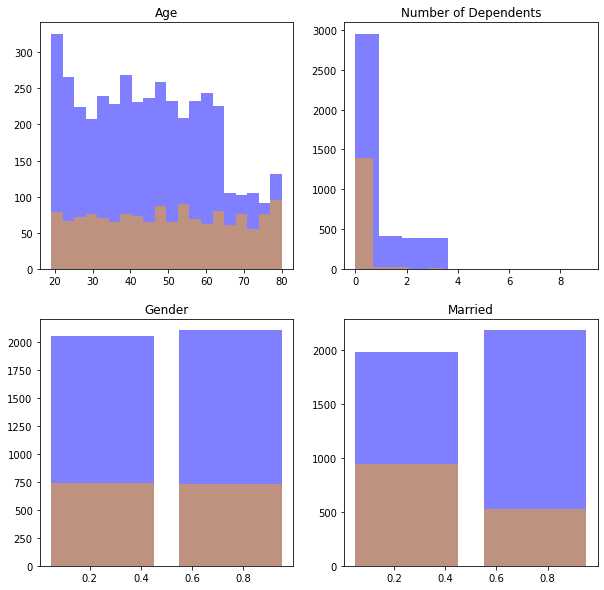

In [14]:
# visualize the distribution of the demographic features vs churn value
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].hist(train[train['Churn Value'] == 0]['Age'], bins=20, color='blue', alpha=0.5)
ax[0, 0].hist(train[train['Churn Value'] == 1]['Age'], bins=20, color='orange', alpha=0.5)
ax[0, 0].set_title('Age')

ax[0, 1].hist(train[train['Churn Value'] == 0]['Number of Dependents'], bins=10, color='blue', alpha=0.5)
ax[0, 1].hist(train[train['Churn Value'] == 1]['Number of Dependents'], bins=10, color='orange', alpha=0.5)
ax[0, 1].set_title('Number of Dependents')

ax[1, 0].hist(train[train['Churn Value'] == 0]['Gender'],
              bins=2, color='blue', alpha=0.5, rwidth=0.8)
ax[1, 0].hist(train[train['Churn Value'] == 1]['Gender'],
              bins=2, color='orange', alpha=0.5, rwidth=0.8)
ax[1, 0].set_title('Gender')

ax[1, 1].hist(train[train['Churn Value'] == 0]['Married'],
              bins=2, color='blue', alpha=0.5,rwidth=0.8)
ax[1, 1].hist(train[train['Churn Value'] == 1]['Married'],
              bins=2, color='orange', alpha=0.5, rwidth=0.8)
ax[1, 1].set_title('Married')

### Initial insights

1. Age seems to be a good predictor of the churn (older people tend to churn more)
2. Gender does not seem to have any effect on the churn rate
3. Hard to tell wether number of dependents has an effect on churn rate further analysis is needed
4. It looks like single people tend to churn more than married people

In [15]:
# perform a correlation analysis on the dataset to see which features are highly correlated
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,Number of Dependents,Churn Value,Gender,Married
Age,1.000000,-0.116894,0.116128,-0.015024,-0.000950
Number of Dependents,-0.116894,1.000000,-0.218793,0.002443,0.320293
Churn Value,0.116128,-0.218793,1.000000,-0.008031,-0.143914
Gender,-0.015024,0.002443,-0.008031,1.000000,-0.001194
Married,-0.000950,0.320293,-0.143914,-0.001194,1.000000


### Correlation matrix analysis
features seem to be uncorrelated with each other
we see positive correlation between churn value and Age
we see negative correlation between churn value and Number of dependents, Married


In [17]:
# let's check non-linear correlations
#sns.pairplot(train, hue='Churn Value')

# Correlation with Spearman's Rank Correlation:
corr = train.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,Age,Number of Dependents,Churn Value,Gender,Married
Age,1.000000,-0.118508,0.109894,-0.015362,-0.003211
Number of Dependents,-0.118508,1.000000,-0.246374,0.001431,0.355396
Churn Value,0.109894,-0.246374,1.000000,-0.008031,-0.143914
Gender,-0.015362,0.001431,-0.008031,1.000000,-0.001194
Married,-0.003211,0.355396,-0.143914,-0.001194,1.000000


In [18]:
# Correlation with Kendall's Rank Correlation:
corr = train.corr(method='kendall')
corr.style.background_gradient(cmap='coolwarm')

,Age,Number of Dependents,Churn Value,Gender,Married
Age,1.000000,-0.093779,0.090492,-0.012649,-0.002644
Number of Dependents,-0.093779,1.000000,-0.237182,0.001378,0.342137
Churn Value,0.090492,-0.237182,1.000000,-0.008031,-0.143914
Gender,-0.012649,0.001378,-0.008031,1.000000,-0.001194
Married,-0.002644,0.342137,-0.143914,-0.001194,1.000000


In [19]:
# Let's build a logistic regression model

# drop the target variable from the training set
X_train = train.drop('Churn Value', axis=1)

# select the target variable from the training set
y_train = train['Churn Value']

# drop the target variable from the test set
X_test = test.drop('Churn Value', axis=1)

# select the target variable from the test set
y_test = test['Churn Value']

# balance the training set
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [22]:
# Define hyperparameter values to be tuned
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.01, 0.1, 1],
              'solver': ['liblinear', 'saga'],
              'class_weight': [None, 'balanced']}

# Create a logistic regression model
logreg = LogisticRegression()

# Create a GridSearchCV object to perform hyperparameter tuning
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy',n_jobs=10)
grid_search.fit(X_train, y_train)

# Get the best hyperparameter
best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

# Fit the logistic regression model with best hyperparameter to the training data
best_logreg = LogisticRegression(**best_params)
best_logreg.fit(X_train, y_train)

# Predict the churn value for the test set
y_pred = best_logreg.predict(X_test)

# Evaluate the model performance
report = classification_report(y_test, y_pred)
print(report)

Best Hyperparameters:  {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
              precision    recall  f1-score   support

           0       0.85      0.48      0.61      1009
           1       0.37      0.78      0.50       400

    accuracy                           0.56      1409
   macro avg       0.61      0.63      0.56      1409
weighted avg       0.71      0.56      0.58      1409



### Logistic regression results analysis

very poor accuracy of 56% on the test set
we see that the model is not able to predict the churn rate of the customers based on the demographic data

In [23]:
# Let's build a random forest model

# Define hyperparameter values to be tuned
param_grid = {
    "n_estimators": [100, 500],
    "max_depth": [5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

# Create a random forest model
rf = RandomForestClassifier()

# Create a GridSearchCV object to perform hyperparameter tuning
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy',n_jobs=10)
grid_search.fit(X_train, y_train)

# Get the best hyperparameter
best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

# Fit the random forest model with best hyperparameter to the training data
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)

# Predict the churn value for the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model performance
report = classification_report(y_test, y_pred)
print(report)

Best Hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.80      0.50      0.62      1009
           1       0.36      0.69      0.47       400

    accuracy                           0.56      1409
   macro avg       0.58      0.60      0.54      1409
weighted avg       0.68      0.56      0.58      1409



In [25]:
# Let's build a SVM model

# Define hyperparameter values to be tuned
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

# Create a SVM model
svm = SVC()

# Create a GridSearchCV object to perform hyperparameter tuning
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy',n_jobs=10)
grid_search.fit(X_train, y_train)

# Get the best hyperparameter
best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

# Fit the SVM model with best hyperparameter to the training data
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Predict the churn value for the test set
y_pred = best_svm.predict(X_test)

# Evaluate the model performance
report = classification_report(y_test, y_pred)
print(report)

Best Hyperparameters:  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.81      0.52      0.63      1009
           1       0.36      0.69      0.47       400

    accuracy                           0.57      1409
   macro avg       0.58      0.60      0.55      1409
weighted avg       0.68      0.57      0.59      1409



#### Results Interpretation:
Based on the results of the three models, it appears that predicting customer churn based solely on demographic features (gender, SeniorCitizen, Partner, and Dependents) is challenging. The best model achieved an accuracy of around 57%, which is only slightly better than random guessing.

The Logistic Regression model had the highest recall score for predicting customer churn (0.78), which means it correctly identified 78% of customers who were likely to churn. However, its precision score for predicting customer churn was low (0.37), which means it also identified a large number of false positives.

The Random Forest and SVM models had similar results with an accuracy of around 56%, and relatively balanced precision and recall scores for predicting customer churn.

Based on these results, it seems that demographic features alone may not be sufficient to accurately predict customer churn. To improve the accuracy of the predictive model, it may be necessary to include additional features.

In [27]:
# save the dataset as an Excel file to use for tableau visualization
dataset.to_excel('q1.xlsx', index=False)
